# FECHADO :)

If you're dealing with a classification problem, you should use SVC in scikit-learn for building your Support Vector Machine model. Here's a step-by-step guide:

# SVM (support vector machine)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, learning_curve

plt.rcParams.update({
        "text.usetex": True,              # If you want to use LaTeX fonts in text
        "font.family": "serif",           # IEEE uses Times New Roman-like fonts
        "font.size": 12,                   # General font size for IEEE format
        "axes.labelsize": 12,              # Axis labels font size
        "legend.fontsize": 11,             # Legend font size
        "xtick.labelsize": 11,             # X-axis tick labels font size
        "ytick.labelsize": 11,             # Y-axis tick labels font size
        "figure.figsize": (5, 5*0.8),
        "savefig.dpi": 900,               # DPI for high-quality PNG/JPEG
        "figure.dpi": 200,
    })

In [30]:
#df = pd.read_csv('08notsmote_FEAUTURES.csv')
df = pd.read_csv('10ma_FEAUTURES.csv')
df.head()

,pEffort,uaI,SleepInd,Sex_F,pEffort(MA6),SleepInd(MA6),uaI(MA6),Appetite(MA6),FatigInd
0,6.0,2.08,-5.00,1,4.678341,-4.713350,2.252252,5.297907,Optimal
1,1.0,2.00,-6.53,1,4.206534,-6.136979,1.997465,6.000013,Optimal
2,1.0,0.00,-4.00,0,3.712435,-3.576147,1.099577,4.884461,Optimal
3,5.0,2.69,-6.00,1,4.685066,-5.692758,2.201203,6.000000,Optimal
4,7.0,2.03,-5.00,1,6.853002,-5.523600,1.905526,6.028801,Optimal


In [31]:
X = df.drop(columns=["FatigInd"])
y = df["FatigInd"]

# standartizar os dados e separar treino de teste

In [32]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2)
X_train.shape, X_test.shape

((511, 8), (128, 8))

## modelo base

The x value that maximizes kf is: 0.8


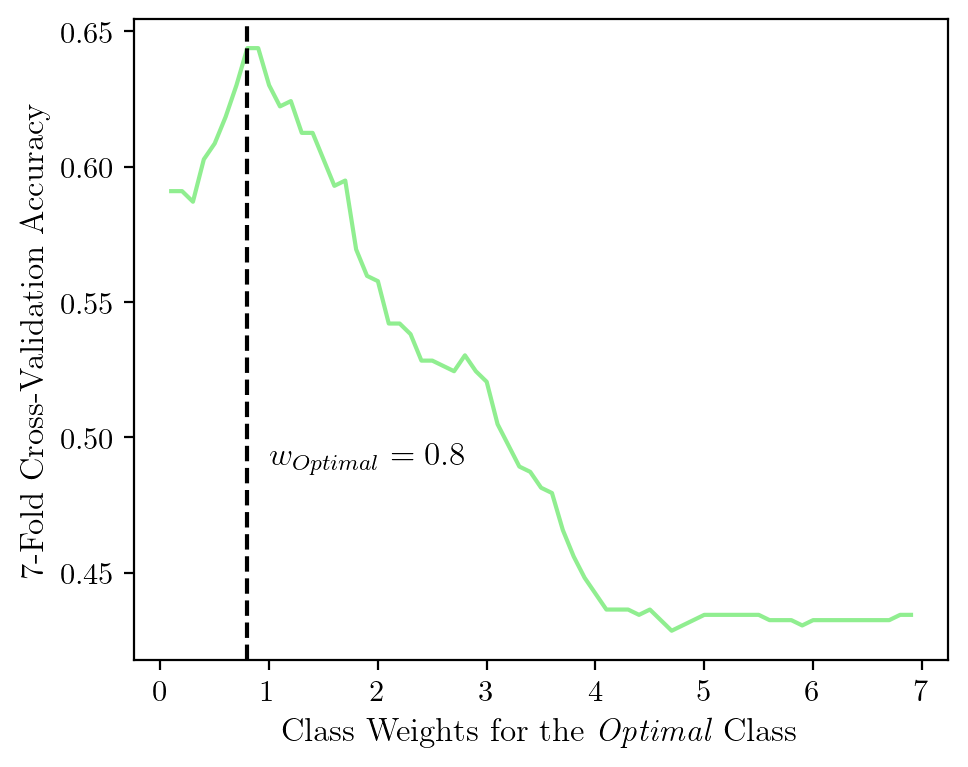

In [33]:
kf = []
weights = np.arange(0.1, 7, 0.1)
for wOP in weights:
    class_weights = {"Low/Minimal": 1, "Optimal": wOP, 'Risk/Caution': 1}  # Increase weight for Class 2
    svc = SVC(class_weight=class_weights)
    scores = cross_val_score(svc, X_train, y_train, cv=7, scoring='accuracy')
    kf.append(scores.mean())
plt.plot(weights, kf, color="lightgreen")
plt.xlabel(r'Class Weights for the \textit{Optimal} Class')
plt.xticks(np.arange(0, 8, 1))
# reta vertical para o valor maximo
plt.axvline(x=weights[np.argmax(kf)], color='black', linestyle='--')
plt.text(np.round(weights[np.argmax(kf)], 2) + .2, 0.49, 
         s=r'$w_{Optimal} = ' + str(round(weights[np.argmax(kf)], 2)) + r'$')
plt.ylabel('7-Fold Cross-Validation Accuracy')
plt.tight_layout()
plt.savefig("assets/SVM_OptimalWeight", transparent=True)

max_index = np.argmax(kf)

# Find the corresponding x value
x_max = weights[max_index]

print("The x value that maximizes kf is:", x_max)

In [34]:
# Define parameter distribution
param_dist = {
    'C': stats.uniform(0, 100), #np.logspace(-3, 3, 7),  # Regularization parameter (log scale)
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Include sigmoid kernel
    'degree': [1, 2, 3],  # Degree for polynomial kernel (only useful for 'poly')
    'coef0': stats.uniform(-5, 5)  # Independent term in kernel
}

# Initialize the SVC model
class_weights = {"Low/Minimal": 1, "Optimal": .8, 'Risk/Caution': 1}  # Increase weight for Class 2
svc = SVC(class_weight=class_weights)

#svc = SVC()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                                   n_iter=500, cv=8, scoring='accuracy', 
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'C': np.float64(6.9254306285859935), 'coef0': np.float64(-0.2008674096203551), 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}


In [35]:
best_svc = random_search.best_estimator_
best_svc.fit(X_train, y_train)

SVC(C=np.float64(6.9254306285859935),
    class_weight={'Low/Minimal': 1, 'Optimal': 0.8, 'Risk/Caution': 1},
    coef0=np.float64(-0.2008674096203551), gamma='auto')

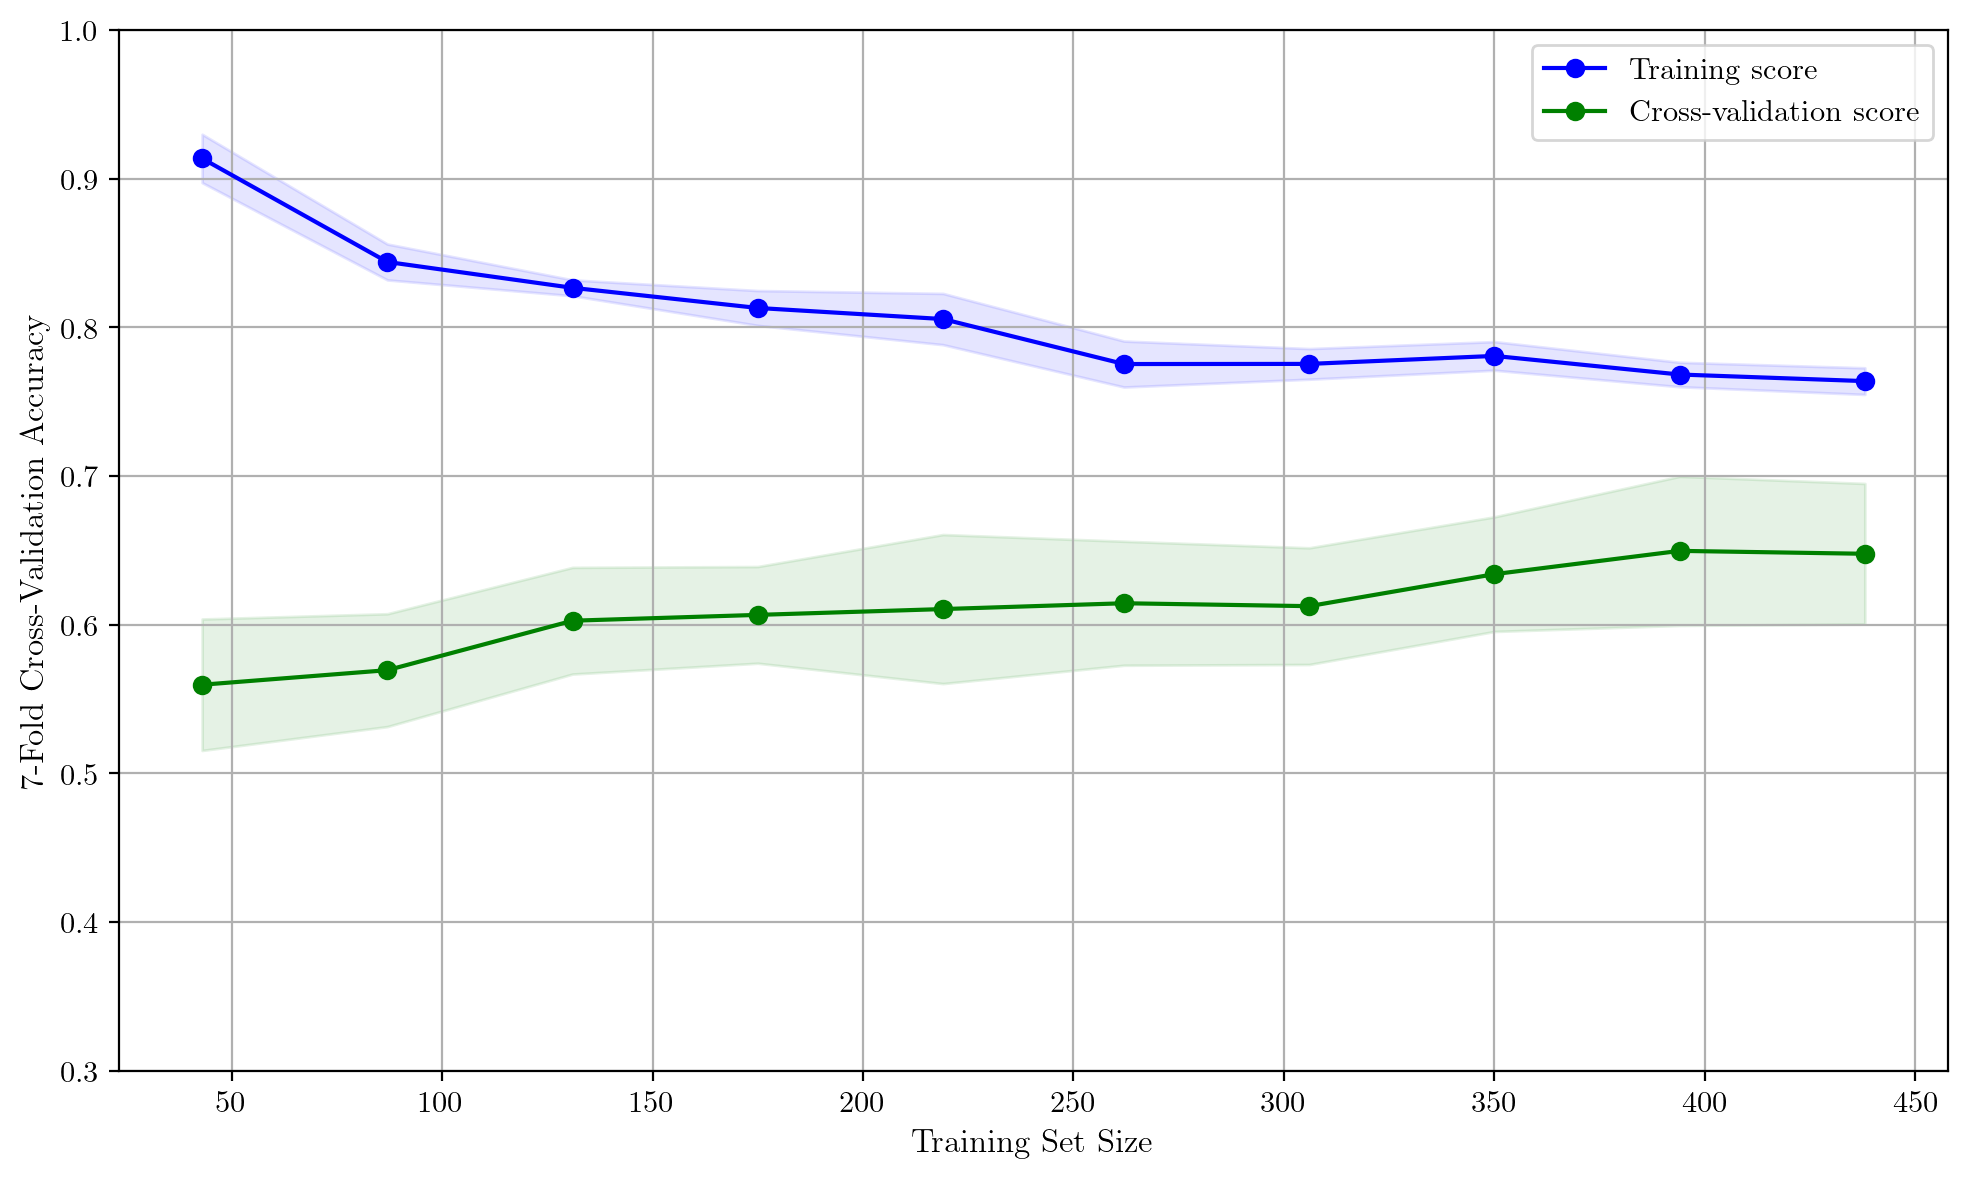

In [36]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_svc, X_train, y_train, cv=7, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
#plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("7-Fold Cross-Validation Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.ylim(0.3, 1)
plt.savefig("assets/SVM_LearningCurve", transparent=True)
plt.show()



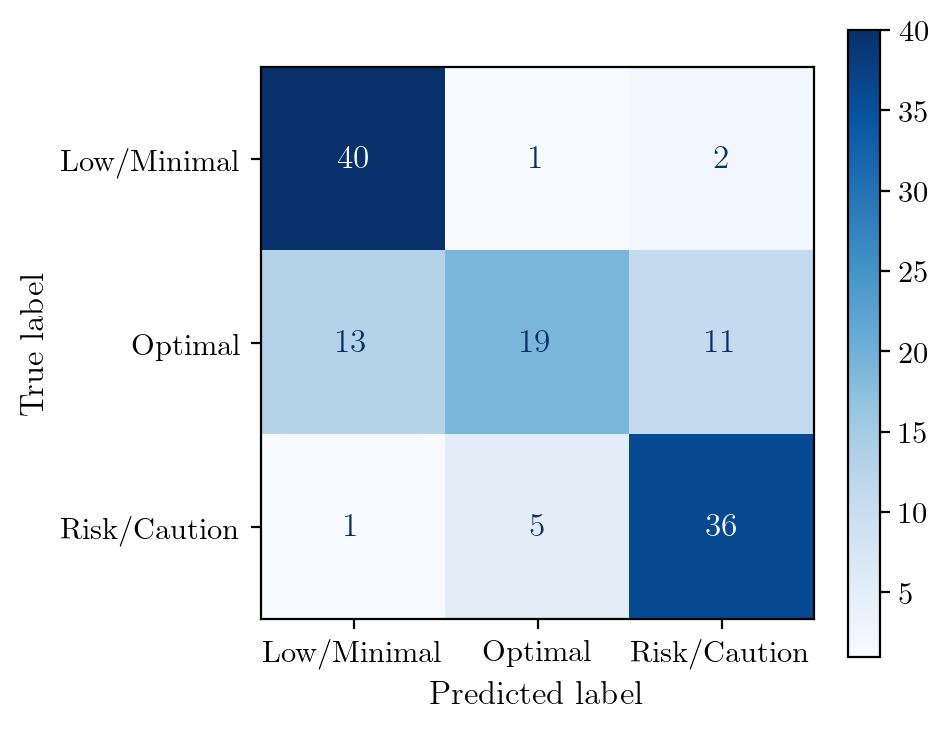

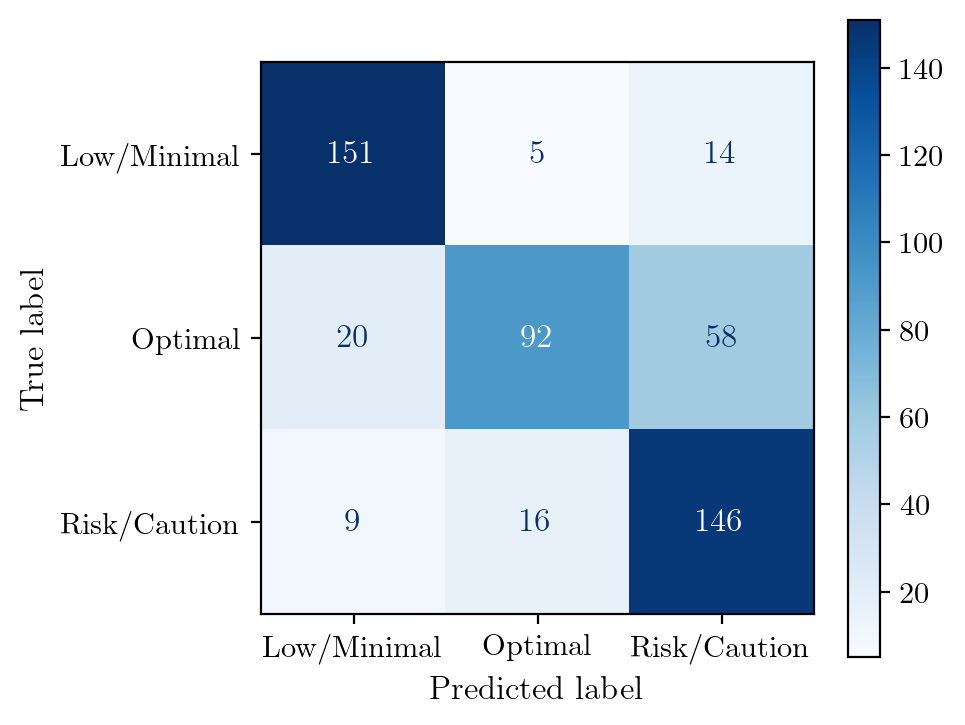

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred_test = best_svc.predict(X_test)

# Generate the confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=best_svc.classes_)
disp_test.plot(cmap="Blues")
#plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.savefig("assets/SVM_ConfusionMatrixTest", transparent=True)
plt.show()

# Optionally, you can also generate confusion matrix for the training set
y_pred_train = best_svc.predict(X_train)

# Generate the confusion matrix for the train set
cm_train = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix for the train set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=best_svc.classes_)
disp_train.plot(cmap="Blues")
#plt.title("Confusion Matrix - Train Set")
plt.tight_layout()
plt.savefig("assets/SVM_ConfusionMatrixTrain", transparent=True)
plt.show()


In [38]:
from sklearn.metrics import classification_report

y_pred_test = best_svc.predict(X_test)
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 Low/Minimal       0.74      0.93      0.82        43
     Optimal       0.76      0.44      0.56        43
Risk/Caution       0.73      0.86      0.79        42

    accuracy                           0.74       128
   macro avg       0.75      0.74      0.72       128
weighted avg       0.75      0.74      0.72       128



In [39]:
y_pred_train = best_svc.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

 Low/Minimal       0.84      0.89      0.86       170
     Optimal       0.81      0.54      0.65       170
Risk/Caution       0.67      0.85      0.75       171

    accuracy                           0.76       511
   macro avg       0.77      0.76      0.75       511
weighted avg       0.77      0.76      0.75       511

